<a href="https://colab.research.google.com/github/AmanuelKBr/PROJECTS_1/blob/main/Fitbit_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # default library for making plots
import seaborn as sns # for making prettier plots!
import datetime
import math

In [3]:
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None) # to see all columns in the pd dataframe
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12.0, 6.0]

In [4]:
data = pd.read_csv('database_main.csv', converters= {'Date': pd.to_datetime})
data.set_index(pd.to_datetime(data.Date),inplace=True)

In [5]:
data.head()

,Unnamed: 0,Date,Day of Week,Is Weekday,Is Weekend,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Active Score,Cardio minutes,Cardio calories,Fat Burn minutes,Fat Burn calories,Peak minutes,Peak calories,Normal Cardio calories,Normal Cardio minutes,Sleep Efficiency,Minutes Asleep,Minutes to fall asleep,Sleep Start time,Sleep End time,Time in bed,Minutes Deep sleep,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-24,0,2018-06-24,7,False,True,1996,1690,3367,3.01,0.00,59.0,0,1377,47,2,14,362,-1,11.0,133.10892,14.0,89.20880,0.0,0.0,446.51352,284.0,92.0,379.0,0.0,2018-06-24T22:17:00.000,2018-06-25T05:28:30.000,431.0,56.0,2.0,244.0,26.0,79.0,6.0,52.0,25.0,13.0,57.0,19.0
2018-06-25,1,2018-06-25,1,True,False,2863,1685,8394,5.55,36.58,58.0,12,709,244,42,14,1361,-1,2.0,12.40518,94.0,514.11279,0.0,0.0,2311.92765,1326.0,95.0,333.0,0.0,2018-06-25T22:49:30.000,2018-06-26T05:16:30.000,387.0,75.0,3.0,214.0,27.0,44.0,7.0,54.0,30.0,20.0,56.0,12.0
2018-06-26,2,2018-06-26,2,True,False,3398,1683,13569,9.68,24.38,57.0,8,687,231,33,102,2004,-1,10.0,103.59112,187.0,1245.54876,0.0,0.0,2034.05724,1232.0,89.0,351.0,0.0,2018-06-26T22:25:30.000,2018-06-27T05:07:30.000,402.0,53.0,3.0,223.0,28.0,75.0,7.0,51.0,29.0,14.0,56.0,19.0
2018-06-27,3,2018-06-27,3,True,False,3442,1682,13337,9.33,33.53,57.0,11,665,243,30,100,2035,-1,11.0,114.28908,217.0,1310.46804,0.0,0.0,1986.03570,1187.0,97.0,365.0,0.0,2018-06-27T22:36:30.000,2018-06-28T05:24:00.000,407.0,66.0,4.0,197.0,32.0,102.0,10.0,42.0,32.0,17.0,49.0,26.0
2018-06-28,4,2018-06-28,4,True,False,1701,1682,559,0.36,18.29,57.0,6,1025,8,0,0,25,-1,0.0,0.00000,0.0,0.00000,0.0,0.0,403.96356,329.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data.drop('Unnamed: 0', inplace=True, axis=1) # since the index is reset as Date.

## Building new columns and sanitising the data
First, remove the activity where there were no steps recorded. For sleep data, clear out rows where there was no "Deep Sleep" entries

In [7]:
dayCodes = ['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
minDayCodes = ['', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

days = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}

def is_nan(x):
    return (x is np.nan or x != x)

def defineSleepBucket(row):
    sleepEntry = row['Sleep Start time']
    if not is_nan(sleepEntry):
        sleepTimeO = datetime.datetime.strptime(sleepEntry, '%Y-%m-%dT%H:%M:%S.000').time()
        if sleepTimeO.minute > 30:
            return (sleepTimeO.hour + 1)
        elif sleepTimeO.minute > 0:
            return sleepTimeO.hour + 0.5
    else:
        return np.nan

def defineAwakeBucket(row):
    awakeEntry = row['Sleep End time']
    if not is_nan(awakeEntry):
        awakeEntryO = datetime.datetime.strptime(awakeEntry, '%Y-%m-%dT%H:%M:%S.000').time()
        if awakeEntryO.minute > 30:
            return (awakeEntryO.hour + 1)
            #return '{}:{}'.format(str((awakeEntryO.hour + 1)), '00')
        elif awakeEntryO.minute > 0:
            return awakeEntryO.hour + 0.5
            #return '{}:{}'.format(str(awakeEntryO.hour), ':30')
    else:
        return np.nan

#remove all entries where there was no steps recorded. i.e no activity
data = data[data['Steps'].notnull()]

data['Day Label'] = data['Day of Week'].apply(lambda x: days[x])
data['Active exercise'] = data['Minutes Very Active'] > 40

#Build additional Sleep columns
data['Sleep Bucket'] = data.apply(defineSleepBucket, axis=1)
data['Awake Bucket'] = data.apply(defineAwakeBucket, axis=1)

data['% Awake'] = 100 - (data['% Deep sleep'] + data['% REM sleep'] + data['% Light sleep'])
data['% Restorative sleep'] = data['% Deep sleep'] + data['% REM sleep']
data['Restorative sleep mins'] = data['Minutes Deep sleep'] + data['Minutes REM sleep']

#remove all entries where there was no Deep sleep recorded
sleepData = data[data['% Deep sleep'].notnull()]

In [8]:
data.describe()

,Date,Day of Week,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Active Score,Cardio minutes,Cardio calories,Fat Burn minutes,Fat Burn calories,Peak minutes,Peak calories,Normal Cardio calories,Normal Cardio minutes,Sleep Efficiency,Minutes Asleep,Minutes to fall asleep,Time in bed,Minutes Deep sleep,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins
count,116,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,101.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.0,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,80.000000,76.000000,80.0,80.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,79.000000,78.000000,76.000000,76.000000,76.000000
mean,2018-08-20 12:00:00,3.974138,2724.560345,1626.422414,8316.163793,5.474741,26.065776,61.267327,8.551724,832.810345,187.767241,24.681034,37.258621,1240.034483,-1.0,7.883495,76.047703,143.631068,752.596613,0.601942,7.668976,1748.720968,1072.893204,95.712500,375.776316,0.0,420.325000,73.526316,3.750000,221.815789,29.723684,80.434211,7.736842,52.842105,30.355263,17.697368,52.250000,19.171053,19.740506,6.692308,10.881579,36.868421,153.960526
min,2018-06-24 00:00:00,1.000000,522.000000,469.000000,0.000000,0.000000,0.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,233.773540,171.000000,89.000000,195.000000,0.0,113.000000,37.000000,1.000000,109.000000,18.000000,21.000000,2.000000,24.000000,16.000000,9.000000,41.000000,10.000000,0.500000,4.500000,6.000000,24.000000,68.000000
25%,2018-07-22 18:00:00,2.000000,2521.750000,1680.000000,6295.750000,4.045000,9.140000,59.000000,3.000000,682.750000,163.750000,4.750000,2.000000,913.500000,-1.0,0.000000,0.000000,74.000000,433.359345,0.000000,0.000000,1630.309950,1039.500000,95.000000,364.250000,0.0,406.750000,60.750000,3.000000,201.750000,27.000000,66.750000,6.000000,44.750000,28.000000,15.000000,48.000000,16.000000,22.500000,6.000000,9.000000,32.750000,130.750000
50%,2018-08-20 12:00:00,4.000000,2877.500000,1680.000000,8630.000000,5.565000,21.340000,62.000000,7.000000,745.500000,198.500000,23.000000,30.500000,1380.000000,-1.0,4.000000,30.583260,144.000000,796.114620,0.000000,0.000000,1902.973380,1185.000000,96.000000,379.500000,0.0,431.000000,73.500000,4.000000,223.000000,30.000000,77.500000,7.000000,51.500000,31.000000,18.000000,53.000000,19.000000,23.000000,6.500000,11.000000,36.000000,153.000000
75%,2018-09-18 06:00:00,6.000000,3116.750000,1680.000000,11275.000000,7.377500,33.530000,63.000000,11.000000,1049.250000,243.250000,38.250000,64.000000,1647.500000,-1.0,13.000000,128.731190,200.500000,1047.770865,0.000000,0.000000,2070.260335,1253.500000,97.000000,394.000000,0.0,444.000000,83.000000,5.000000,244.750000,33.000000,94.250000,9.000000,58.250000,33.250000,20.000000,57.000000,23.000000,23.000000,7.000000,12.000000,41.000000,169.000000
max,2018-10-17 00:00:00,7.000000,4085.000000,1690.000000,25570.000000,16.620000,320.040000,68.000000,105.000000,1440.000000,581.000000,78.000000,135.000000,3089.000000,-1.0,49.000000,548.374750,517.000000,1736.347200,10.000000,123.341330,2452.870800,1403.000000,99.000000,489.000000,0.0,574.000000,113.000000,6.000000,316.000000,44.000000,145.000000,17.000000,92.000000,41.000000,26.000000,63.000000,30.000000,24.000000,17.000000,19.000000,50.000000,253.000000
std,NaN,2.023605,653.985218,233.791031,4398.676997,2.959660,36.176807,3.036087,11.869101,309.649982,100.007944,20.114714,35.085268,648.341214,0.0,10.061868,99.803739,91.585917,417.497794,1.762016,22.699727,507.443689,3

Behavior weekdays vs weekends

In [9]:
dayTypeGroupedData = data.groupby('Is Weekday').mean(numeric_only=True)
dayTypeGroupedData

,Day of Week,Is Weekend,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Active Score,Cardio minutes,Cardio calories,Fat Burn minutes,Fat Burn calories,Peak minutes,Peak calories,Normal Cardio calories,Normal Cardio minutes,Sleep Efficiency,Minutes Asleep,Minutes to fall asleep,Time in bed,Minutes Deep sleep,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins
Is Weekday,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,6.515152,1.0,2679.545455,1667.606061,8789.909091,5.716061,33.527879,61.666667,11.000000,943.090909,215.515152,20.181818,26.272727,1222.242424,-1.0,7.037037,54.388412,136.666667,659.956047,0.074074,0.950886,1774.602004,1025.777778,95.380952,376.450000,0.0,414.428571,73.150000,3.400,219.250000,28.900000,84.050000,7.650000,51.900000,28.850000,17.750000,51.750000,19.750000,0.272727,16.452381,7.333333,10.750000,37.500000,157.200000
True,2.963855,0.0,2742.457831,1610.048193,8127.807229,5.378795,23.098916,61.121622,7.578313,788.963855,176.734940,26.469880,41.626506,1247.108434,-1.0,8.184211,83.742450,146.105263,785.508394,0.789474,10.055665,1739.526390,1089.631579,95.830508,375.535714,0.0,422.423729,73.660714,3.875,222.732143,30.017857,79.142857,7.767857,53.178571,30.892857,17.678571,52.428571,18.964286,0.457831,20.931034,6.456140,10.928571,36.642857,152.803571


In [10]:
dayGroupedData = data.groupby(['Day of Week']).mean(numeric_only=True)
dayGroupedData

,Is Weekday,Is Weekend,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Active Score,Cardio minutes,Cardio calories,Fat Burn minutes,Fat Burn calories,Peak minutes,Peak calories,Normal Cardio calories,Normal Cardio minutes,Sleep Efficiency,Minutes Asleep,Minutes to fall asleep,Time in bed,Minutes Deep sleep,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins
Day of Week,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,2766.764706,1679.764706,7474.117647,4.756471,35.142353,61.200000,11.529412,892.235294,197.647059,27.470588,24.470588,1188.058824,-1.0,3.933333,39.324835,147.266667,723.268431,0.000000,0.000000,1884.135575,1165.733333,95.875000,374.200000,0.0,425.812500,68.533333,3.533333,226.200000,29.600000,79.466667,8.133333,52.866667,30.866667,16.466667,53.400000,19.066667,0.117647,23.033333,6.218750,11.066667,35.533333,148.000000
2,1.0,0.0,2932.000000,1613.529412,9709.941176,6.495294,19.542941,60.625000,6.411765,695.588235,192.470588,31.411765,62.705882,1517.058824,-1.0,9.823529,102.797649,160.176471,917.109046,1.058824,13.772624,1782.886879,1125.058824,94.846154,377.416667,0.0,427.538462,72.666667,3.833333,225.333333,29.750000,79.416667,8.000000,52.833333,31.166667,17.583333,52.750000,19.000000,0.705882,21.192308,6.153846,10.666667,36.583333,152.083333
3,1.0,0.0,2848.588235,1611.411765,8856.588235,5.938235,22.770000,60.823529,7.470588,749.647059,179.705882,31.176471,51.411765,1370.058824,-1.0,9.117647,90.933628,153.647059,835.312679,0.823529,10.401669,1620.286221,1010.647059,96.769231,371.230769,0.0,419.615385,75.307692,4.153846,217.384615,30.384615,78.538462,6.923077,48.384615,30.769231,18.384615,52.230769,19.153846,0.705882,19.538462,6.083333,10.230769,37.538462,153.846154
4,1.0,0.0,2695.375000,1604.187500,7546.250000,5.081250,20.955000,61.500000,6.875000,806.750000,166.437500,26.625000,38.187500,1184.937500,-1.0,10.142857,101.458271,150.642857,810.832673,0.571429,6.402520,1711.505051,1085.357143,96.000000,386.363636,0.0,443.636364,83.000000,4.272727,224.454545,31.000000,78.909091,8.181818,57.272727,31.545455,19.181818,51.272727,18.181818,0.437500,21.000000,6.550000,11.363636,37.363636,161.909091
5,1.0,0.0,2449.562500,1536.687500,6948.562500,4.556875,16.574375,61.666667,5.437500,802.437500,144.937500,15.000000,30.500000,954.562500,-1.0,7.615385,81.592786,111.615385,592.829592,1.538462,20.279408,1702.073737,1063.384615,95.500000,362.400000,0.0,369.500000,66.600000,3.400000,216.200000,28.800000,79.600000,7.400000,58.400000,29.200000,16.400000,51.800000,19.800000,0.312500,18.000000,8.333333,12.000000,36.200000,146.200000
6,0.0,1.0,2884.000000,1679.500000,10655.500000,6.877500,43.625000,62.076923,14.312500,955.437500,228.187500,26.875000,36.687500,1424.812500,-1.0,6.538462,55.732043,173.769231,903.743161,0.076923,0.951635,1759.771382,994.000000,95.500000,361.100000,0.0,412.500000,66.600000,3.300000,207.700000,28.400000,86.800000,8.000000,51.400000,27.600000,17.100000,51.200000,20.900000,0.437500,10.900000,8.100000,10.800000,38.000000,153.400000
7,0.0,1.0,2487.117647,1656.411765,7034.058824,4.622941,24.024706,61.285714,7.882353,931.470588,203.588235,13.882353,16.470588,1031.588235,-1.0,7.500000,53.140755,102.214286,433.582299,0.071429,0.950190,1788.373296,1055.285714,95.272727,391.800000,0.0,416.181818,79.700000,3.500000,230.800000,29.400000,81.300000,7.300000,52.400000,30.100000,18.400000,52.300000,18.600000,0.117647,21.500000,6.636364,10.700000,37.000000,161.000000


---
## Utilities

In [11]:
def getDayLabel(dayNum):
    return dayCodes[dayNum]

def plot_heatmap(corrmat, correlationOf, title, darkTheme=False):
    if darkTheme:
        sns.set(style='darkgrid', palette='deep') # Using Seaborn for making heatmap
        cmap="YlGnBu"
    else:
        sns.set(style = "white")
        cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corrmat, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    plt.figure(figsize=(10, 10))
    hm = sns.heatmap(corrmat, mask=mask, cbar=True, annot=True, square=True, fmt='.2f',
                 annot_kws={'size': 10}, cmap=cmap)
    hm.set_title(title)
    plt.yticks(rotation=0)
    plt.show()

---
# Activity Analysis

In [12]:
data[['Calories Burned', 'Steps', 'Minutes Sedentary', 'Minutes Fairly Active', 'Minutes Very Active', 'Cardio minutes', 'Fat Burn minutes', 'Active exercise', 'Resting Heart Rate']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Calories Burned,116.0,2724.560345,653.985218,522.0,2521.75,2877.5,3116.75,4085.0
Steps,116.0,8316.163793,4398.676997,0.0,6295.75,8630.0,11275.00,25570.0
Minutes Sedentary,116.0,832.810345,309.649982,0.0,682.75,745.5,1049.25,1440.0
Minutes Fairly Active,116.0,24.681034,20.114714,0.0,4.75,23.0,38.25,78.0
Minutes Very Active,116.0,37.258621,35.085268,0.0,2.00,30.5,64.00,135.0
Cardio minutes,103.0,7.883495,10.061868,0.0,0.00,4.0,13.00,49.0
Fat Burn minutes,103.0,143.631068,91.585917,0.0,74.00,144.0,200.50,517.0
Resting Heart Rate,101.0,61.267327,3.036087,55.0,59.00,62.0,63.00,68.0


Text(0, 0.5, 'Minutes Very Active')

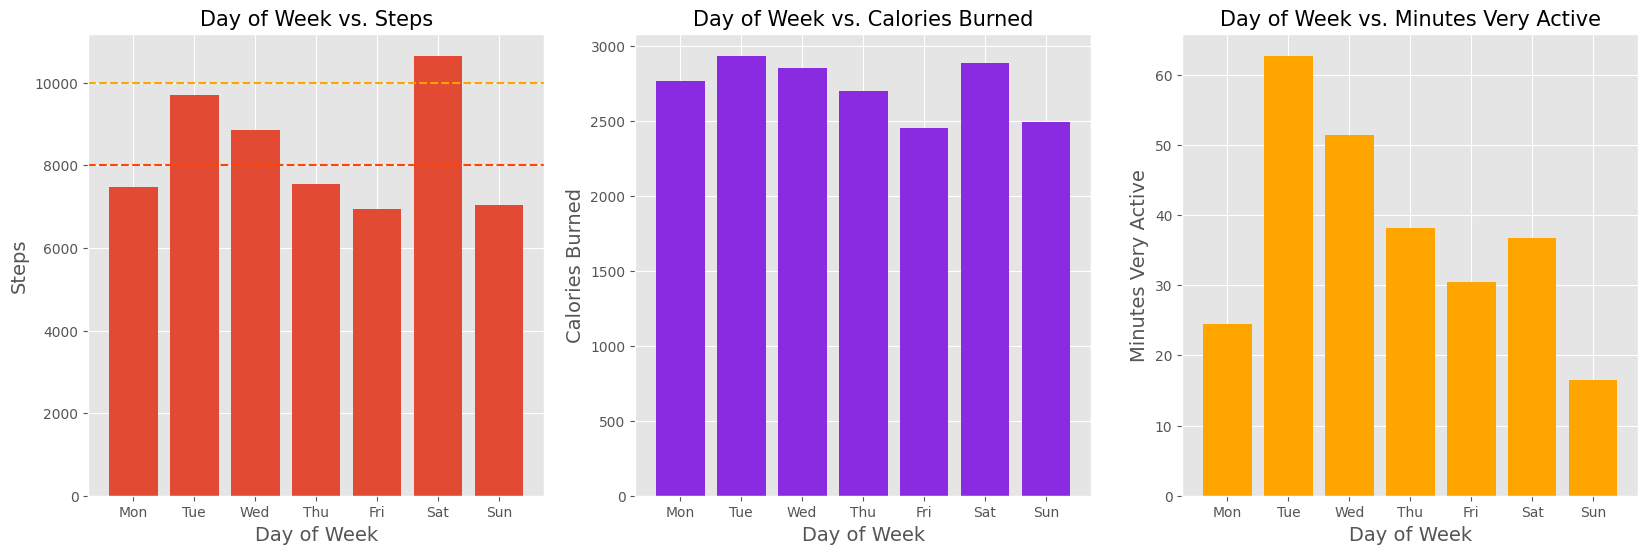

In [13]:
fig = plt.figure(figsize = (20,6))

ax = plt.subplot(131)
plt.bar(dayGroupedData.index, dayGroupedData['Steps'])
plt.title('Day of Week vs. Steps', fontsize=15)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Steps', fontsize=14)
ax.axhline(8000, color="orangered", linestyle='--')
ax.axhline(10000, color="orange", linestyle='--')
ax.set_xticklabels(minDayCodes)

#############

ax2 = fig.add_subplot(132)
plt.bar(dayGroupedData.index, dayGroupedData['Calories Burned'], color='blueviolet')
plt.title('Day of Week vs. Calories Burned', fontsize=15)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Calories Burned', fontsize=14)
ax2.set_xticklabels(minDayCodes)

#############

ax3 = fig.add_subplot(133)
ax3.set_xticklabels(minDayCodes)
plt.bar(dayGroupedData.index, dayGroupedData['Minutes Very Active'], color='orange')
plt.title('Day of Week vs. Minutes Very Active', fontsize=15)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Minutes Very Active', fontsize=14)

Not fussing on the daily calorie burn, I had kept a goal of attaining 8000 steps count each day on my Fitbit device. The graphs below suggested I am averaging about ~7800 steps per day which is a quite close to my goal. There are some studies which suggest hitting 10000 steps per day is ideal and that shall be the next target.

Tuesdays to Saturdays were the days where I averaged about 40 minutes of very active minutes - which simply translates to active exercise. Fewer minutes on Sundays were due to purely due to laziness/recovery time. The drop in active minutes on Mondays proves that I am falling for the Monday Blues and guess it's time to fix that 💪🏼

## 2. Sedentary minutes

Text(0.5, 1.0, '"Sedentary minutes" per day')

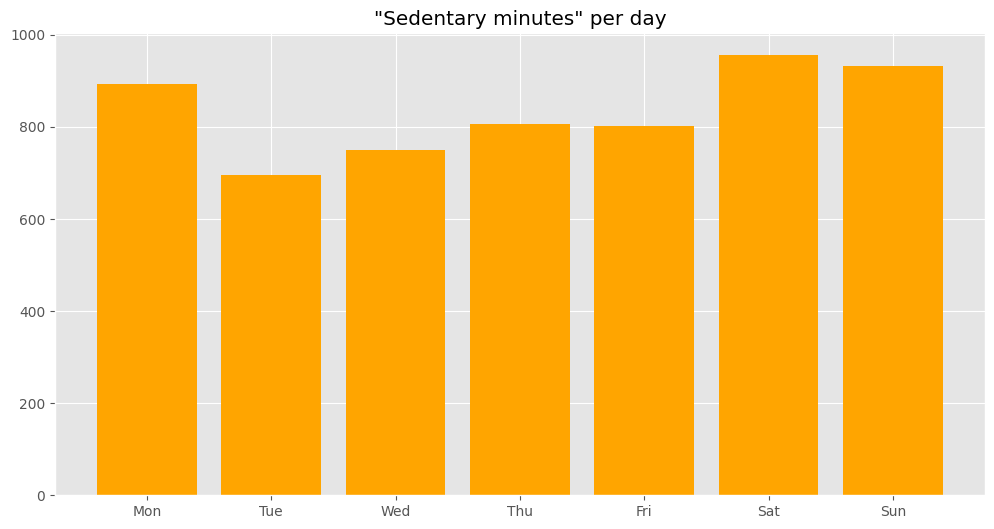

In [15]:
plt.bar(dayGroupedData.index, dayGroupedData['Minutes Sedentary'], color='orange', tick_label=minDayCodes[1:])
plt.title('"Sedentary minutes" per day')

## Average heart rate / calorie burn rate per min / vs exercise type

Analysing the amount of calories burned per minutes for various Activities shows some interesting findings. Though there is a lot of similar data available on internet, it is very difficult to generalise these numbers for everyone. Since, lot of this depends on the fitness levels, demographics, skillset and most importantly how much I enjoy doing some specific exercises.

In [16]:
activityDf = pd.read_csv('/content/database_main_2.csv')
activityDf['Cal/Min'] = activityDf['Calories burned']/activityDf['Time']
groupedActivitiesDf = activityDf.groupby(['Activity Type']).mean(numeric_only=True)

,Time,avgBPM,maxBPM,Calories burned,Steps,Cal/Min
Activity Type,,,,,,
Fitbit Coach,10.000000,131.0,149.0,86.000000,5.0,8.600000
Running,9.000000,149.0,183.0,107.000000,1202.0,11.825000
Squash,44.000000,139.0,170.0,427.000000,4366.0,9.704545
Swim,20.333333,0.0,0.0,77.666667,97.0,3.876400
Tennis,35.000000,144.0,176.0,357.000000,2507.0,10.200000
Walk,20.000000,121.0,164.0,182.000000,2239.0,9.100000
Weight training,21.000000,136.0,166.0,203.000000,100.0,9.666667


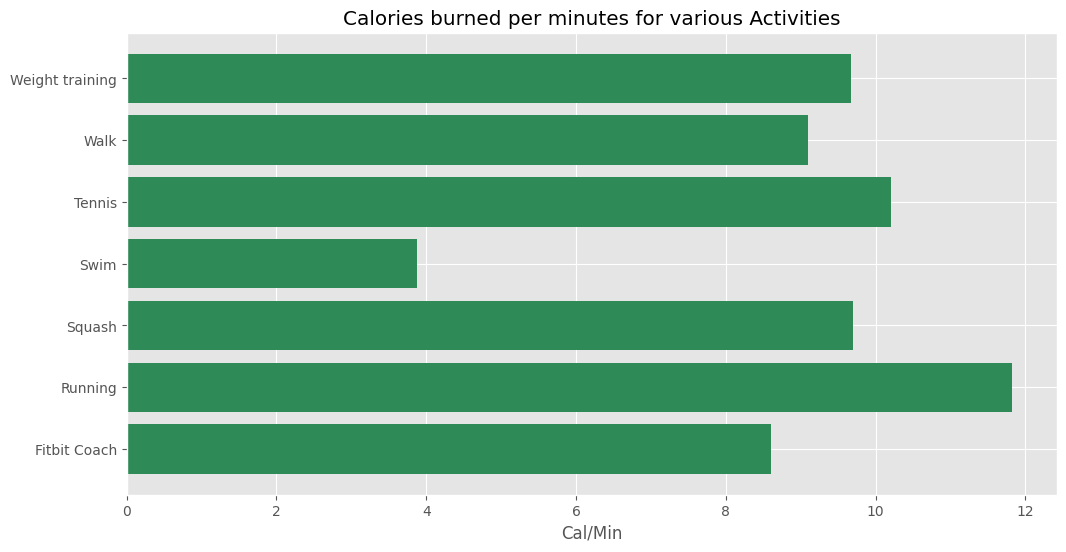

In [17]:
#Plot Data
plt.barh(groupedActivitiesDf.index, groupedActivitiesDf['Cal/Min'], color='seagreen')
plt.title('Calories burned per minutes for various Activities')
plt.xlabel('Cal/Min')
plt.plot()

groupedActivitiesDf

It is interesting to see that running helps me burn almost 12 calories per minute. The maths is simple, to compensate for a beer, a 10 minutes runs is what I need. 🏃🏻‍+ 🕑 = 🍺

Tennis 🎾 - the favourite activity from the lot - takes the second spot. That's again a win-win scenario! It will be interesting to see if this number changes as I improve my skills.

Swimming numbers were not shocking to me because I am still struggling to keep up with my continuous lap count. And after spending some time in pool, the exercise turns to a leisure activity.

Point to note here is that calories burned should not be the only metric on which these activities can be graded. But, this happens to be the only metric which I can currently measure via Fitbit.

## 3. Calorie burn coorelation

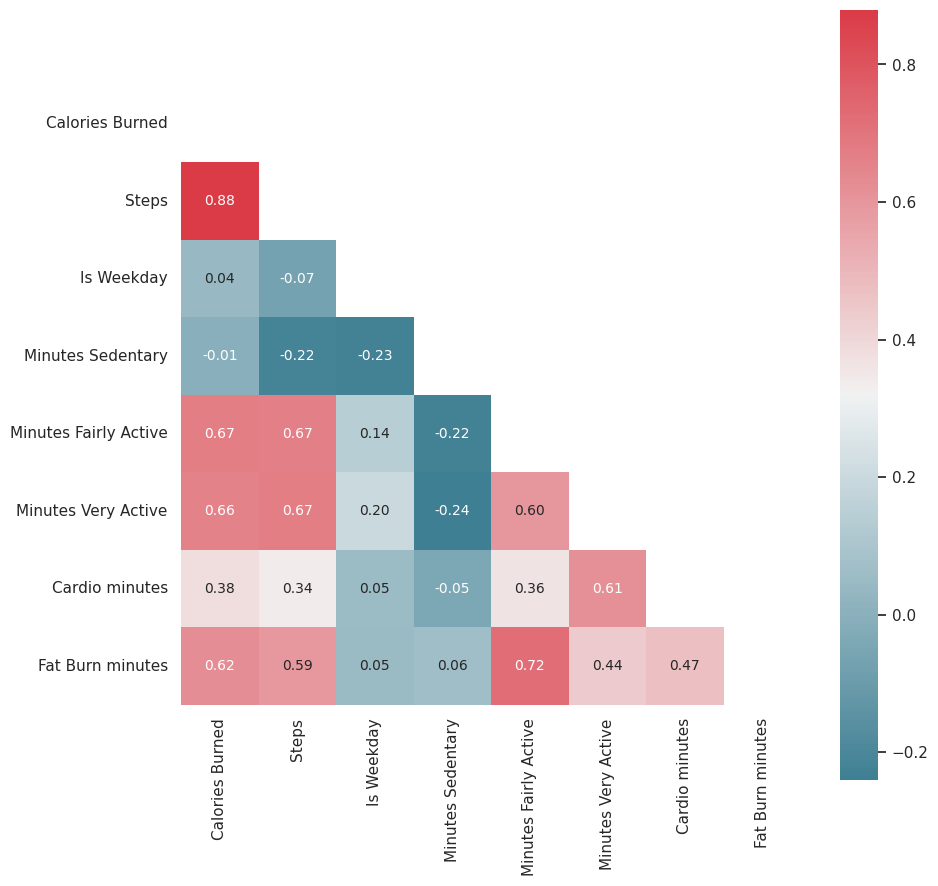

In [18]:
correlationOf = 'Calories Burned'
corrdf_calories = data[['Calories Burned','Steps', 'Is Weekday', 'Minutes Sedentary', 'Minutes Fairly Active', 'Minutes Very Active', 'Cardio minutes', 'Fat Burn minutes']]
plot_heatmap(corrdf_calories.corr(), correlationOf, '')

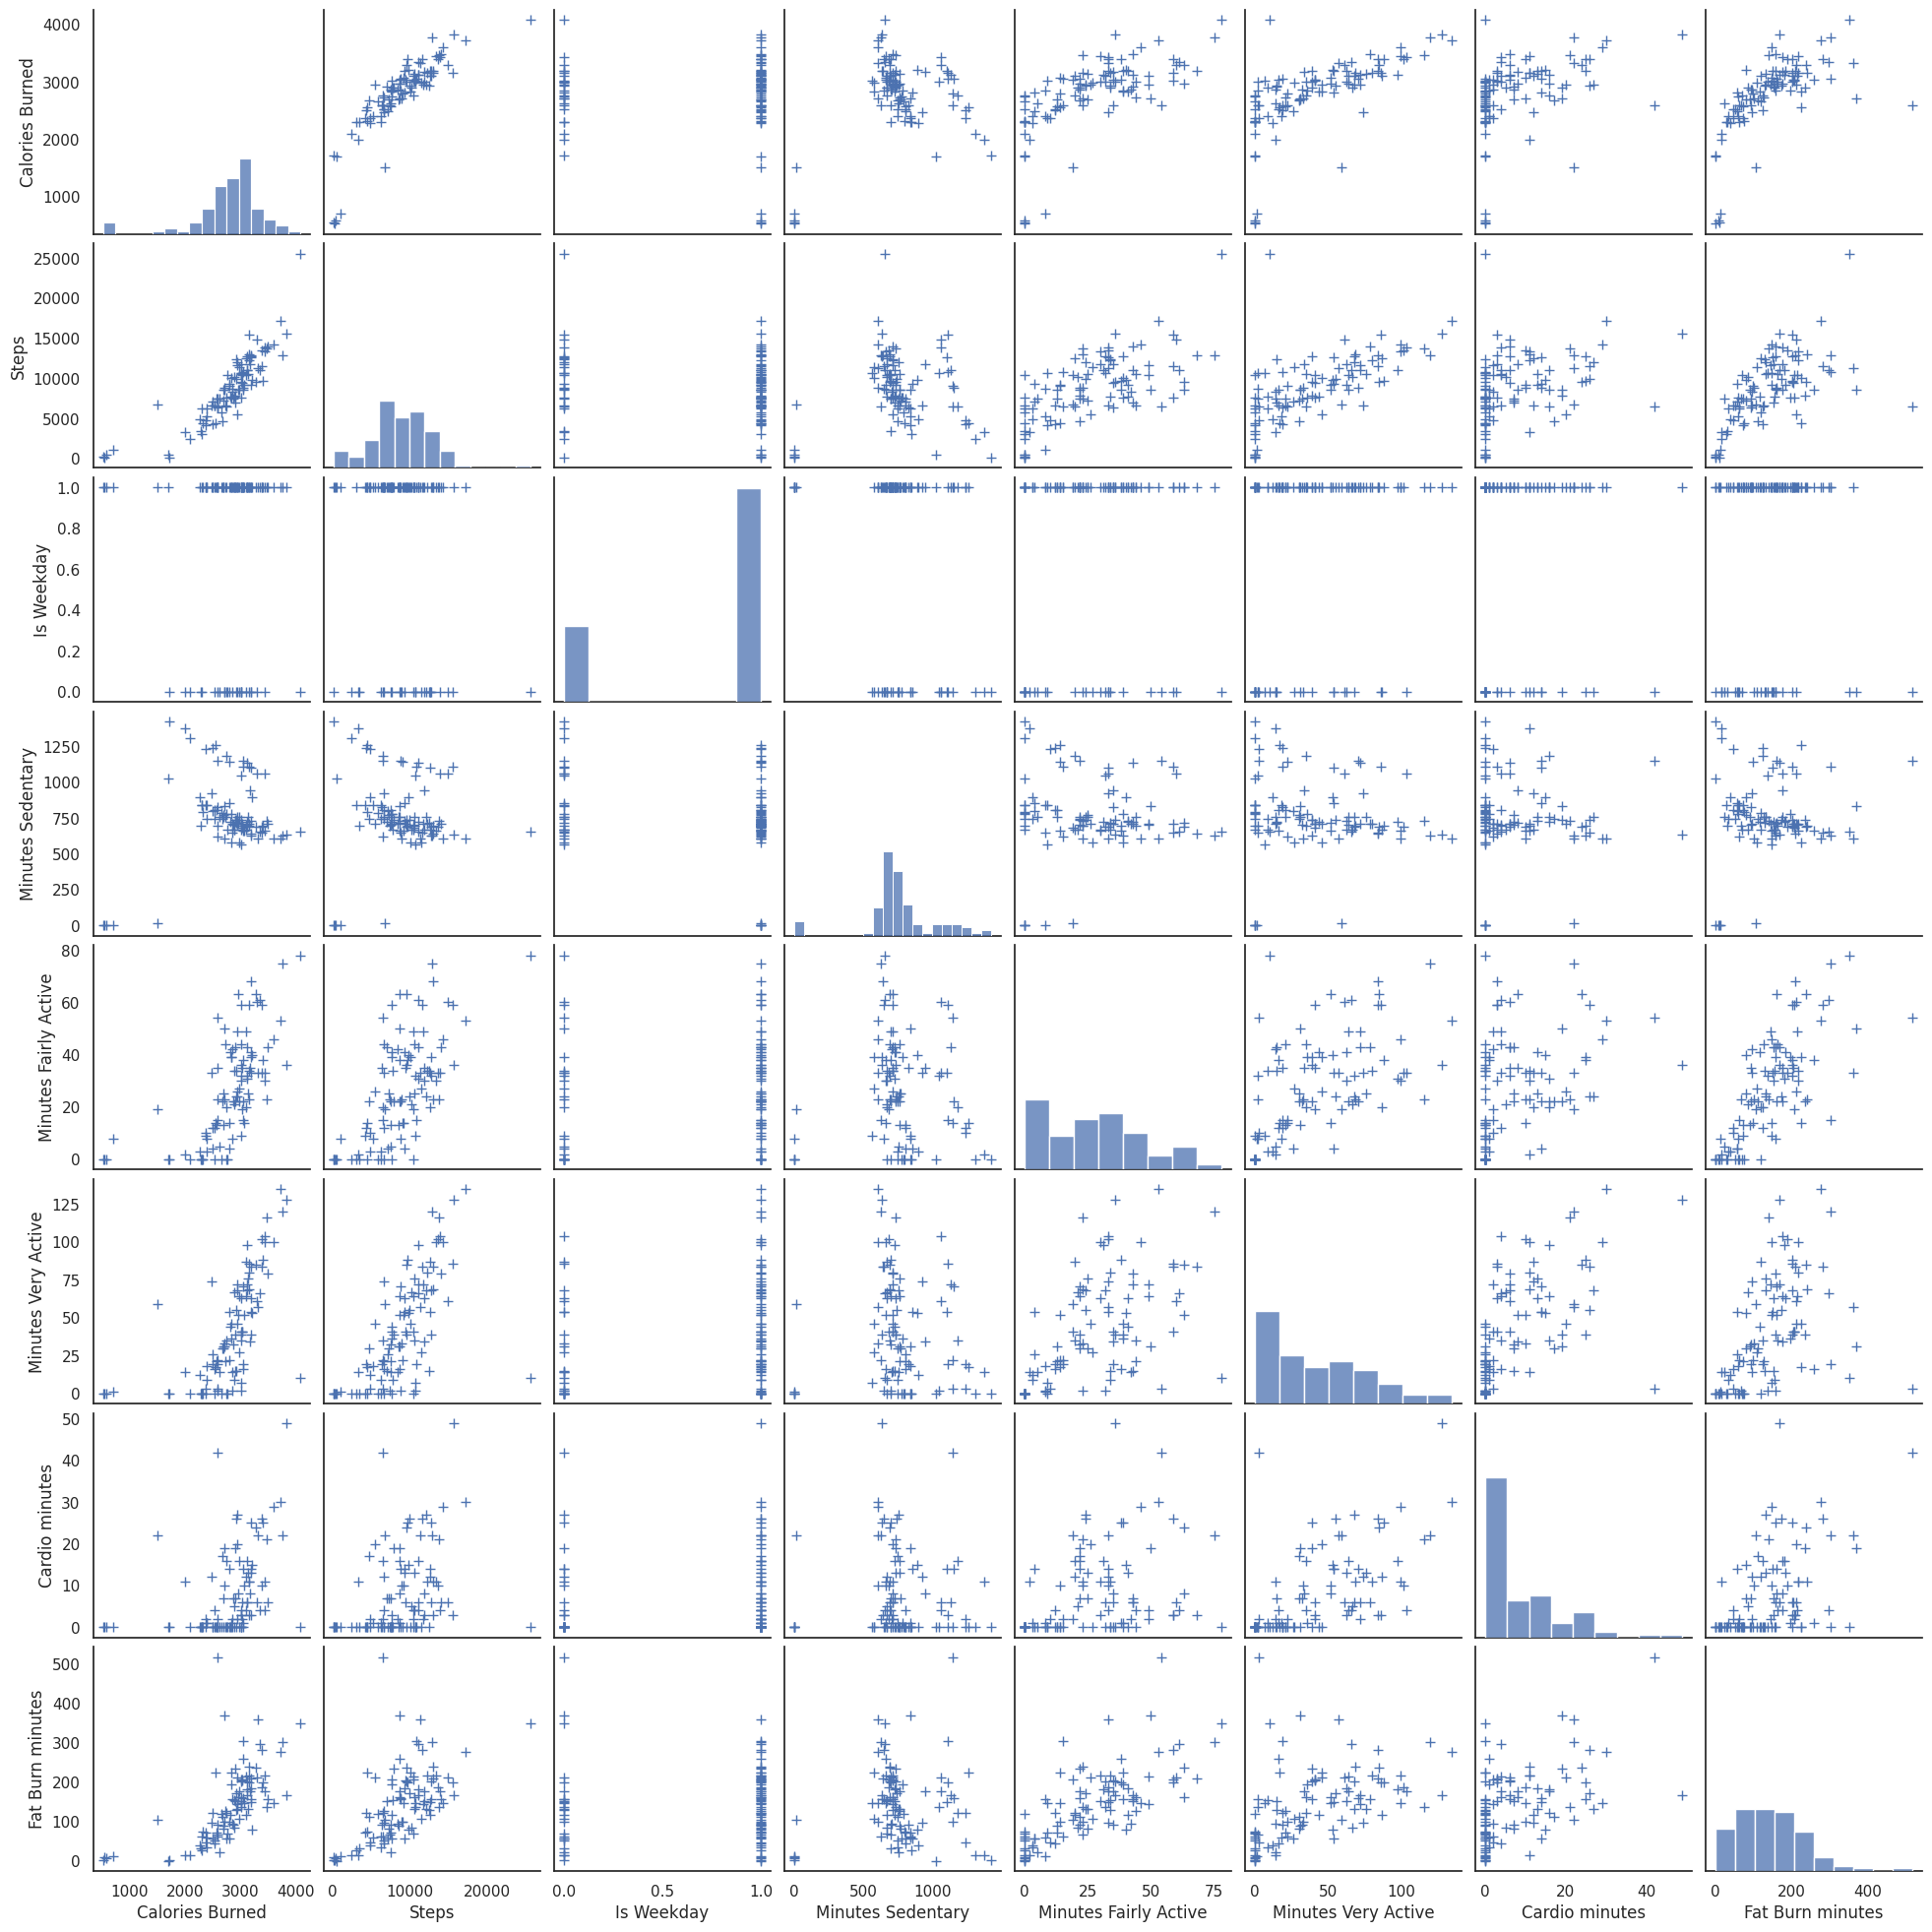

In [19]:
# Basic correlogram
sns.pairplot(corrdf_calories.dropna(), kind="scatter", markers="+", plot_kws=dict(s=50, edgecolor="b", linewidth=1))
plt.show()

The calories burned is strongly related to amount of steps and active minutes. Minutes sedentary has a negative correlation with Weekdays which implies that I spend more time slacking off on weekends.

---
# Sleep Analysis

Sleep is essential to helping maintain mood, memory, and cognitive performance and there is no running from it. We spend about a third of our life in sleeping. That's a staggering 26 years spent sleeping in bed! While metabolism generally slows down, all major organs and regulatory systems continue to function. Hence, it becomes important to get the most out of our sleep.

Reading more on this, I found that there are some standard ways which can help achieve a good night sleep.
* Following a good sleep schedule
* Avoid bright/blue light at night before hitting the bed
* Avoid caffeine later in the day
* Sleep in a cool and dark room
* Getting at-least 7–9 hours of sleep. There are some studies which say that even in 5 hours you can achieve the most out of your sleep.

Over the course of this experiment, I tried to follow the above steps to bind myself to a strict sleep schedule. It was time to validate them.

## 1. How regular is my sleeping habits?

 - Am I getting the required hours of sleep? - Average sleep hours and the deviation
 - Am I following a good sleep schedule? - Average sleep and wake up timings

,count,mean,std,min,25%,50%,75%,max
Time in bed,76.0,7.14364,0.821759,3.65,6.895833,7.225,7.454167,9.566667


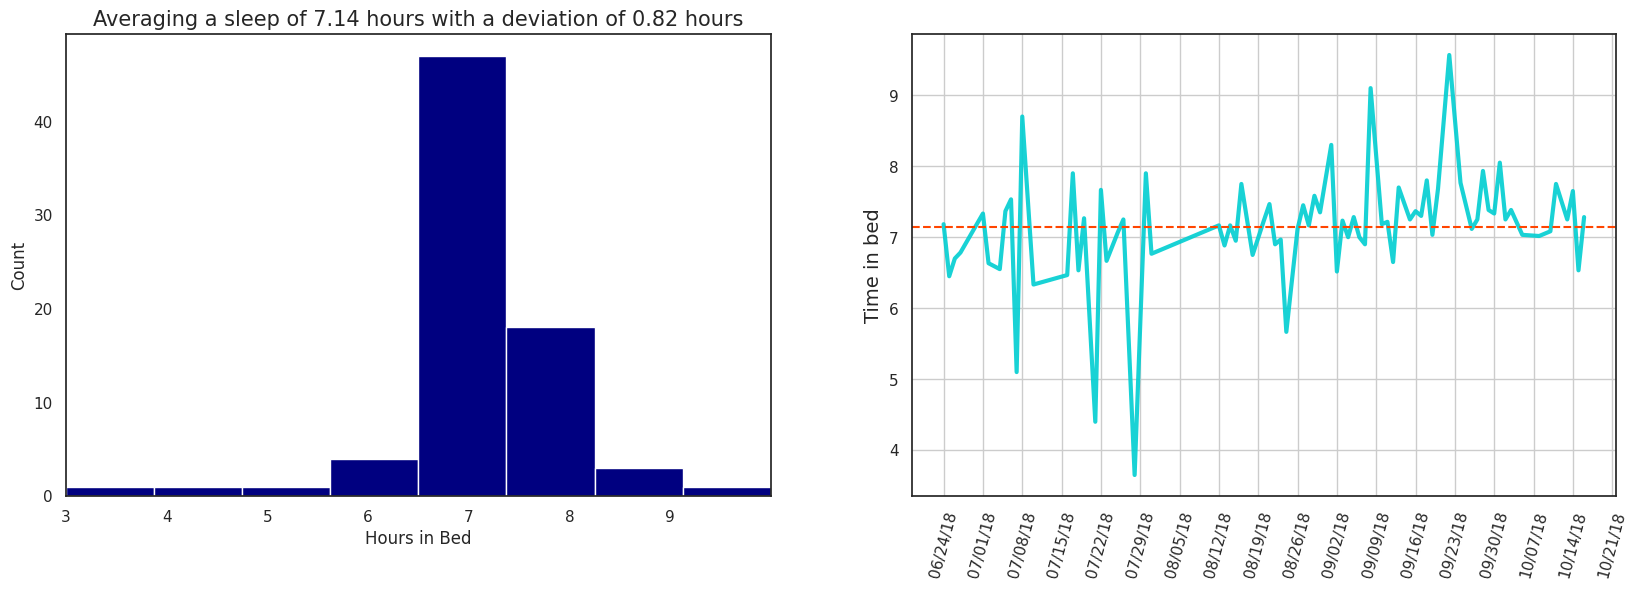

In [20]:
import matplotlib.dates as mdates

sleepDesc = pd.DataFrame(sleepData['Time in bed']/60).describe().transpose()
avgSleepHours = round(sleepDesc.at['Time in bed','mean'],2)
summary = 'Averaging a sleep of {} hours with a deviation of {} hours'.format(avgSleepHours, round(sleepDesc.at['Time in bed','std'],2))
hoursInBed = sleepData['Time in bed']/60

fig = plt.figure(figsize = (20,6))

ax = plt.subplot(121)
plt.hist(hoursInBed, bins = 8, range = (3, 10), color="navy")
plt.xlim(3, 10)
plt.xticks(range(3, 10))
plt.xlabel('Hours in Bed')
plt.ylabel('Count');
plt.title(summary, fontsize=15)

#############

ax2 = fig.add_subplot(122)
plt.plot(sleepData['Date'],hoursInBed, linestyle='-',
         markersize=10, color='darkturquoise', label='% Light', linewidth=3.0, alpha=0.9)
plt.ylabel('Time in bed', fontsize=14)
ax2.axhline(avgSleepHours, color="orangered", linestyle='--')
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=6))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%D'))
ax2.grid(True)
plt.xticks(rotation=75)
plt.plot()

sleepDesc

As far as behavioral data goes, this is reasonably well-behaved. Notice that this distribution doesn't vary much and is quite steep. The deviation is of less than an hour.

On the other note, according to [National Sleep Foundation](https://www.sleepfoundation.org/how-sleep-works/how-much-sleep-do-we-really-need/page/0/2) I should be getting sleep between 7-9 hours. Looks like barely scratching the mark here! 😅

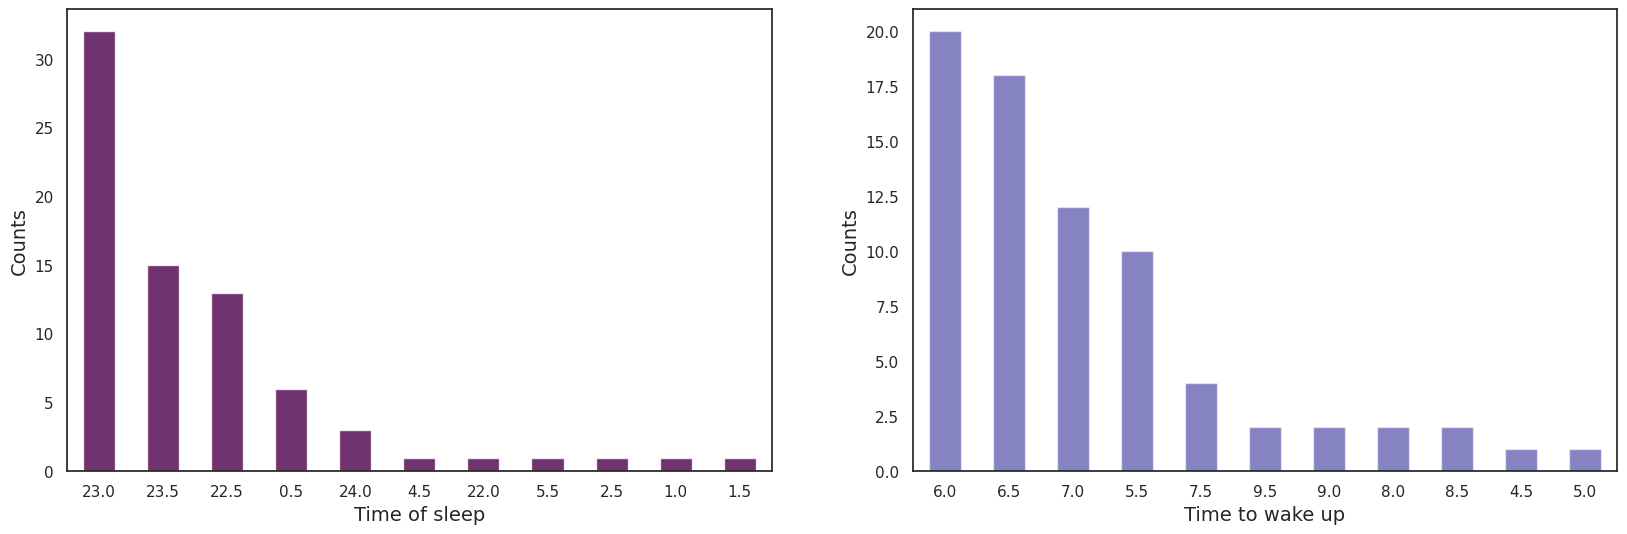

In [21]:
sleepBDF = sleepData[['Sleep Bucket', 'Awake Bucket', 'Time in bed']]
sleepBDF['Time in bed'] = sleepBDF['Time in bed']/60

## plot the sleep and awake counts
fig = plt.figure(figsize = (20,6))

ax = plt.subplot(121)
pd.value_counts(sleepData['Sleep Bucket']).plot.bar(cmap="BuPu_r", alpha=0.8)
plt.xlabel('Time of sleep', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(rotation=0)

#############

ax2 = fig.add_subplot(122)
pd.value_counts(sleepData['Awake Bucket']).plot.bar(cmap="plasma", alpha=0.5)
plt.xlabel('Time to wake up', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(rotation=0)
plt.show()

## 2. Types of sleep

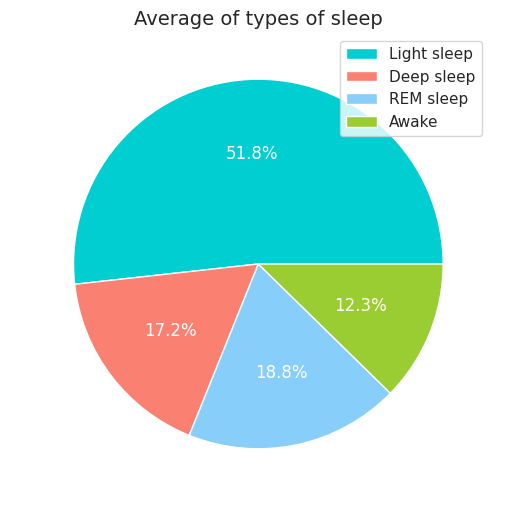

In [22]:
avgSleep = sleepData[['Minutes Light sleep', 'Minutes Deep sleep', 'Minutes REM sleep', 'Minutes Awake']].mean()

fig = plt.figure(figsize = (6,6))
labels=['Light sleep', 'Deep sleep', 'REM sleep', 'Awake']
plt.pie(avgSleep, colors = ['darkturquoise', 'salmon', 'lightskyblue', 'yellowgreen'], autopct='%1.1f%%', labels=labels, textprops=dict(color="w"))

plt.title('Average of types of sleep', fontsize=14)
plt.legend()
plt.show()

The pie chart above shows that on an average, my body spends just about 17% in Deep sleep, 19% REM and rest in either light or being slightly awake.

## 3. Correlation between amount of sleep and the sleep stages.
Do sleeping more will help me attain more deep or REM sleep?

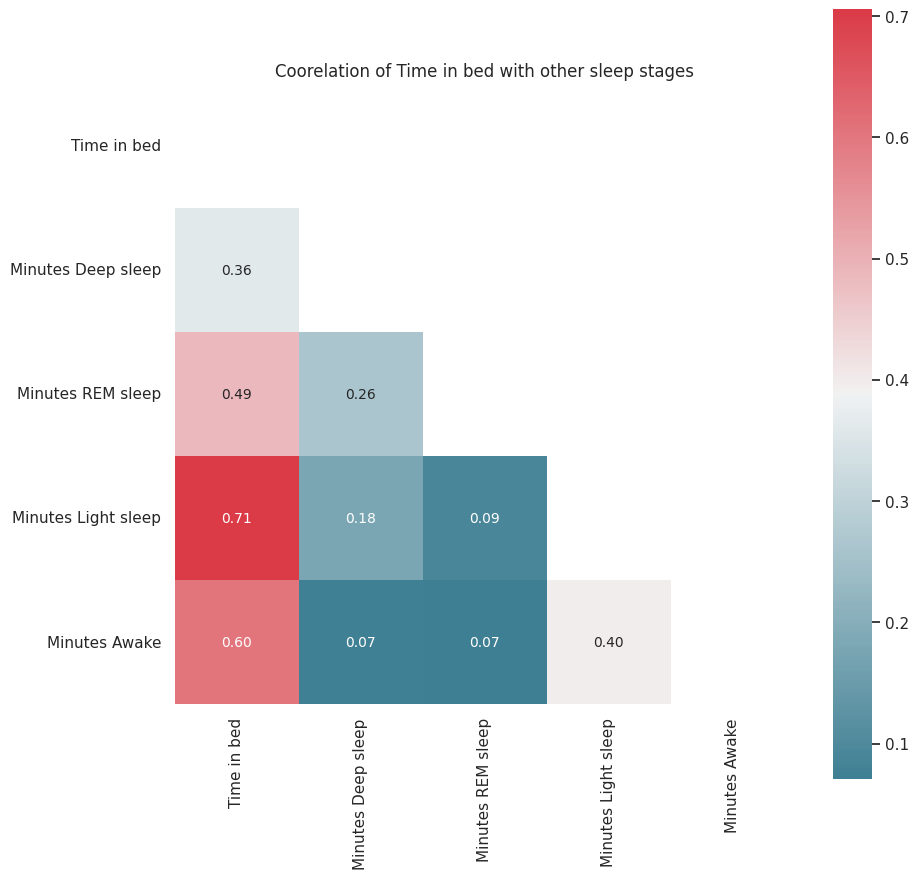

,Time in bed,Minutes Deep sleep,Minutes REM sleep,Minutes Light sleep,Minutes Awake
Time in bed,1.000000,0.363047,0.485731,0.705513,0.604619
Minutes Deep sleep,0.363047,1.000000,0.262515,0.178520,0.074543
Minutes REM sleep,0.485731,0.262515,1.000000,0.092427,0.070540
Minutes Light sleep,0.705513,0.178520,0.092427,1.000000,0.395523
Minutes Awake,0.604619,0.074543,0.070540,0.395523,1.000000


In [23]:
corrdf_sleep_types = sleepData[['Time in bed', 'Minutes Deep sleep', 'Minutes REM sleep', 'Minutes Light sleep', 'Minutes Awake']].corr().abs()
plot_heatmap(corrdf_sleep_types, correlationOf, 'Coorelation of Time in bed with other sleep stages')
corrdf_sleep_types

Notice that the "Deep sleep minutes" are not very coorelated with the time in bed.
Which shows that sleepinng more doesn't necessarily guarantee a good deep sleep.

## 4. Types of Sleep based on different days

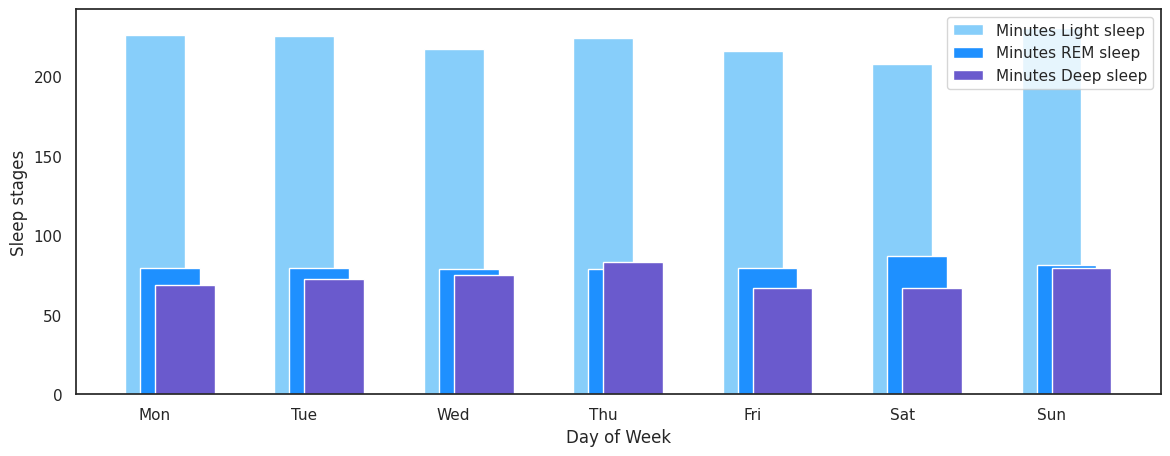

In [24]:
fig = plt.figure(figsize = (14,5))
plt.bar((dayGroupedData.index), dayGroupedData['Minutes Light sleep'],width = 0.4, color='lightskyblue', label="Minutes Light sleep", tick_label=minDayCodes[1:])
plt.bar((dayGroupedData.index + 0.1), dayGroupedData['Minutes REM sleep'], width = 0.4, color='dodgerblue', label="Minutes REM sleep")
plt.bar((dayGroupedData.index + 0.2), dayGroupedData['Minutes Deep sleep'], width = 0.4, color='slateblue', label="Minutes Deep sleep")
plt.xlabel('Day of Week')
plt.ylabel('Sleep stages')
plt.legend()

Analysis on different days of the week: did I sleep more on weekends?

## 5. Effect of Sleep on Weekdays 💼 vs Weekends 🎪

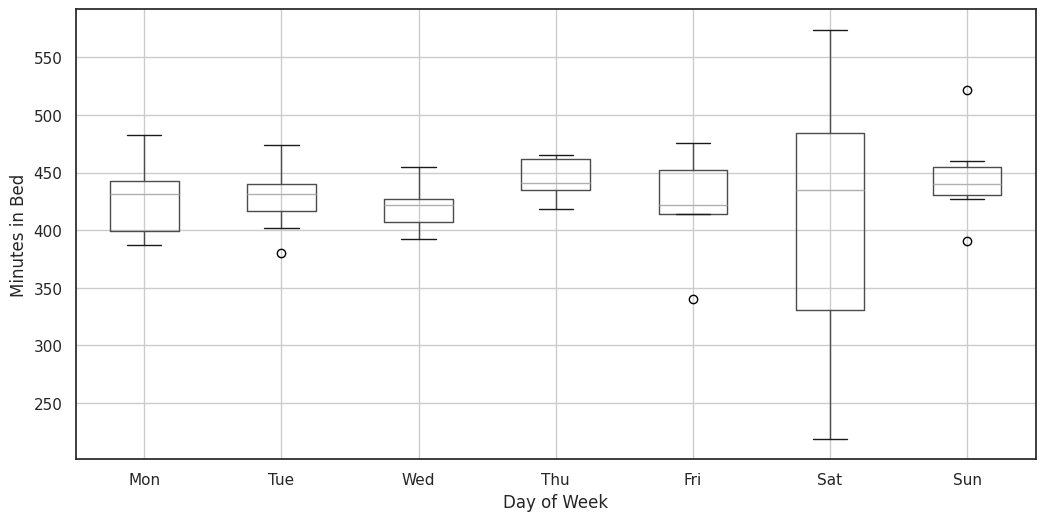

In [25]:
ax = sleepData.boxplot(column = 'Time in bed', by = 'Day of Week')
ax.set_xticklabels(minDayCodes[1:])
plt.ylabel('Minutes in Bed')
plt.suptitle('')
plt.title('');

This is pretty interesting.
The rest of the days are straighforward with lesser deviations but from the looks of it, I have exploited saturday night sleep for sure!

## Coorelation of sleep with other activity numbers

In [26]:
sleepData['8 > Sleep > 7'] = sleepData['Time in bed'] > 7*60
sleepData['Sleep > 7'] = sleepData['Time in bed'] > 7*60
sleepData['Sleep > 8'] = sleepData['Time in bed'] > 8*60
sleepData['Active mins > 50'] = sleepData['Minutes Very Active'] > 50
sleepData['Active mins > 60'] = sleepData['Minutes Very Active'] > 60

sleepData['wee'] = np.logical_and(sleepData['Sleep Bucket'] <= 23, sleepData['Awake Bucket'] <= 6.5)

In [27]:
correlationOf="Minutes Deep sleep"
k = 15 #number of variables for heatmap
corrmat = sleepData[['Minutes Deep sleep', 'Minutes Very Active', 'Minutes Fairly Active', 'Minutes Lightly Active', 'Minutes Sedentary', 'Calories Burned', 'Steps',
          'Cardio minutes', 'Fat Burn minutes', 'Peak minutes',
          '8 > Sleep > 7', 'wee', 'Sleep > 8', 'Active mins > 60', 'Is Weekday']].corr()

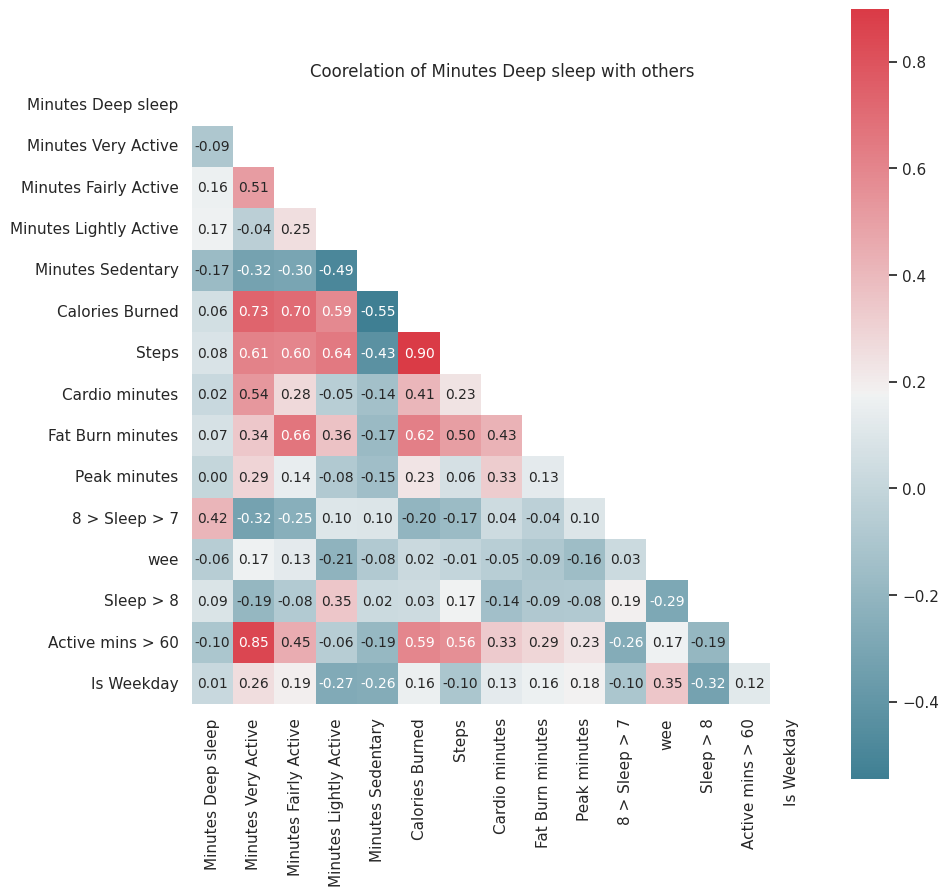

In [28]:
plot_heatmap(corrmat, correlationOf, 'Coorelation of {} with others'.format(correlationOf), darkTheme=False)

## Correlation Matrix Insights

**Observations:**
- I found a moderate positive correlation (~0.51) between *Minutes Deep Sleep* and *Minutes Fairly Active* 🚶‍♂️, suggesting that moderate activity boosts my deep sleep.
- A notable positive relationship (~0.41) exists between *Deep Sleep* and *Cardio Minutes* 🚴‍♀️, indicating that regular cardio enhances my sleep quality.
- There is a negative correlation with *Is Weekday* 🎉, meaning I tend to sleep deeper on weekends.
- Lighter activities like *Steps* and *Lightly Active Minutes* show small positive effects on my deep sleep 👣.
- *Calories Burned* and *Peak Minutes* have weak correlations 🔍, suggesting they are less influential on sleep quality.

**Actionable Insights:**
1. **Increase Moderate Activity:**  
   I will keep a steady schedule of brisk walks and light runs 🚶‍♂️ to enhance my deep sleep.

2. **Enhance Cardio Workouts:**  
   I plan to include regular cardio sessions 🚴‍♀️ to further improve my sleep quality.

3. **Prioritize Weekend Rest:**  
   I will use weekends to focus on rest and recovery 🛌 for better sleep.

4. **Stay Consistently Active:**  
   I will continue monitoring my step count and light activities 👣 to maintain overall health.
